In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

In [2]:
processed_train = pd.read_excel('processed_train.xlsx',index_col=0)
processed_test = pd.read_excel('processed_test.xlsx',index_col=0)

In [3]:
processed_test.head()

,admission number,Age,Sex,Follow_up time,Revasc,Culp,MainVASc,Numsten,ECG,Killip,...,UA,Glu,WBC,N,HyperP,Cigaret,OtherHis,diabetes,Drugcom,MACE
358,1047495,45,0,403,108,4,3,1,1,1,...,117.000000,5.30,6.520000,4.540000,0,1,1,1,1,0
19,899915,67,0,659,1110,2,2,3,1,3,...,718.000000,6.93,11.970000,10.790000,1,1,1,0,1,0
294,1065946,50,0,315,540,3,4,0,0,1,...,336.266667,5.69,9.946667,22.388009,0,1,0,0,1,0
194,869417,72,0,707,4368,3,3,1,0,2,...,495.000000,8.71,9.600000,7.790000,1,0,1,0,1,0
117,896240,59,0,664,330,4,3,2,0,1,...,370.000000,9.24,10.020000,5.430000,0,0,0,0,1,0


In [4]:
#removing binary discrete features whose variance below 0.09
from sklearn.feature_selection import VarianceThreshold
#drop MACE(true label) and irrelevant feature(admission number)
Bin_X_dre = processed_train[['Sex','ECG','HyperP','Cigaret','OtherHis','diabetes','Drugcom']]
#normalization of X
Bin_X_dre=(Bin_X_dre-np.min(Bin_X_dre))/(np.max(Bin_X_dre)-np.min(Bin_X_dre)).values
sel = VarianceThreshold(threshold=(.9 * (1 - .9)))
selfeature = sel.fit_transform(Bin_X_dre)
print(Bin_X_dre.shape,selfeature.shape)
#No binary discrete features was excluded

(244, 7) (244, 7)


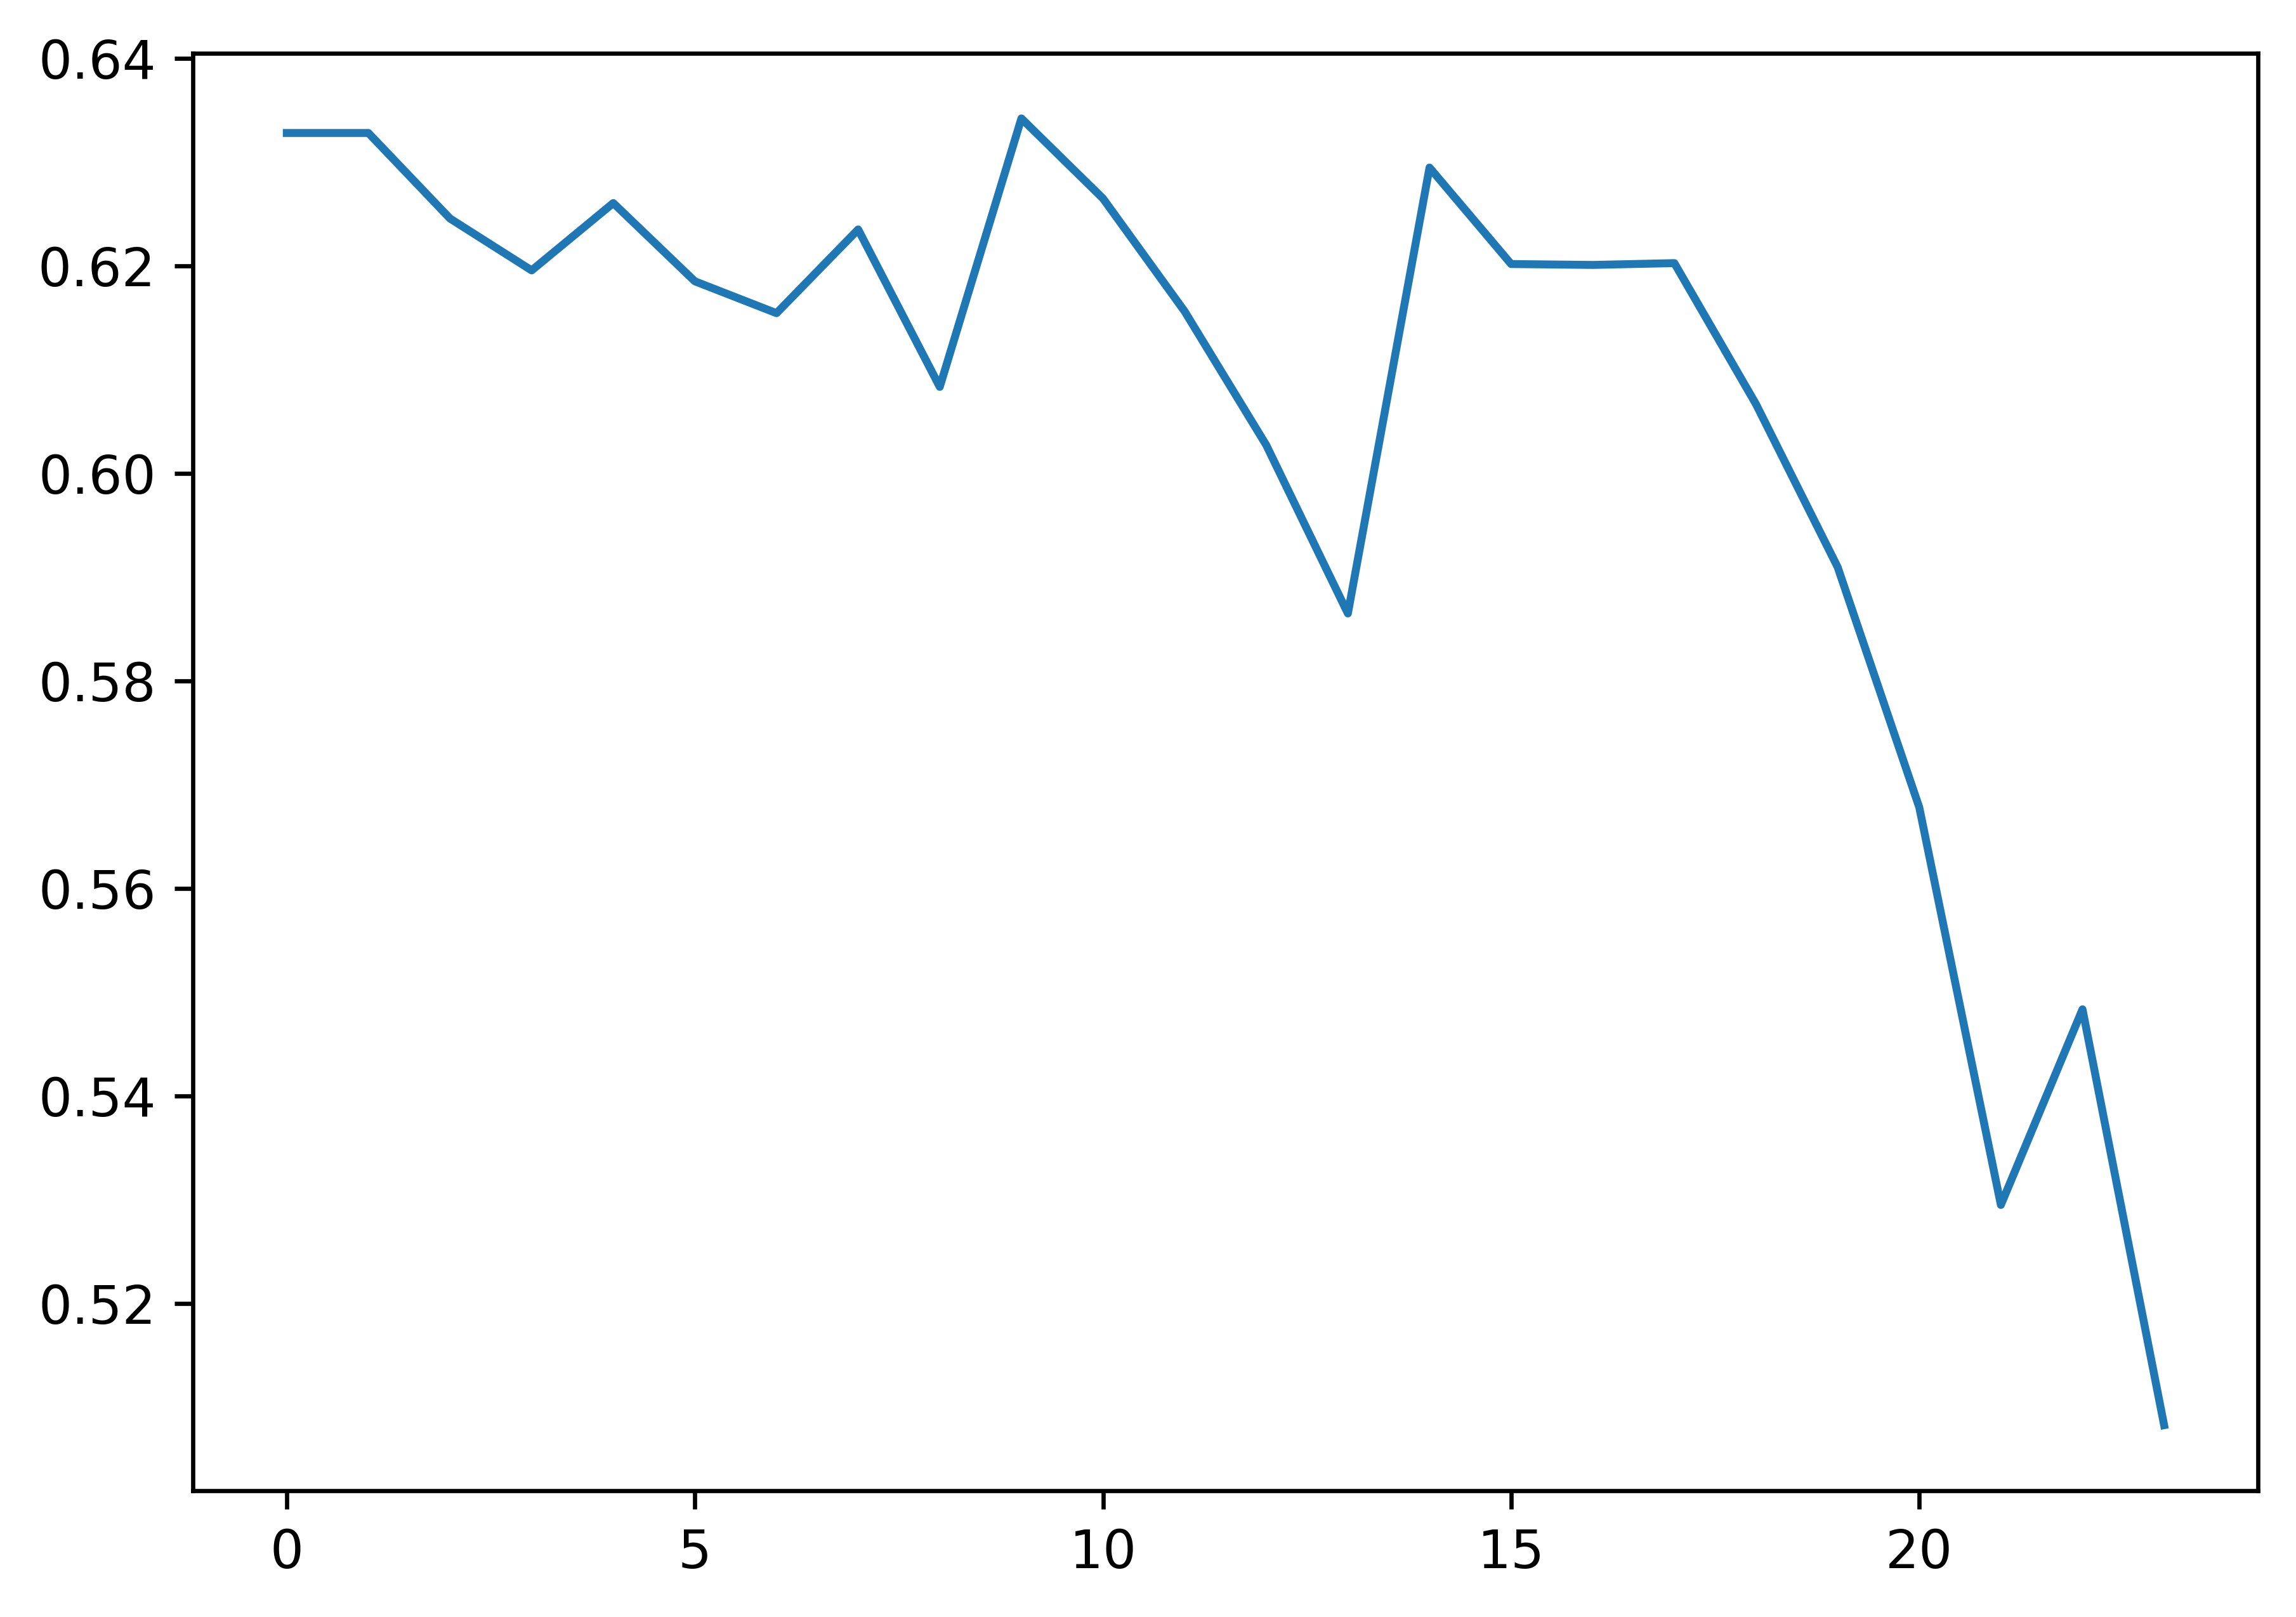

In [5]:
#Recursive feature elimination
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve,auc
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt

X = processed_train.drop(['MACE','admission number'], axis = 1)
X=(X-np.min(X))/(np.max(X)-np.min(X)).values
y = processed_train['MACE'] # Target variable

X_test = processed_test.drop(['MACE','admission number'], axis = 1)
X_test=(X_test-np.min(X_test))/(np.max(X_test)-np.min(X_test)).values
y_test = processed_test['MACE'] # Target variable

# Create the RFE object and rank each pixel
rdf = RandomForestClassifier(random_state=1)
AUC = []

rdf.fit(X,y)
y_proba =rdf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba,pos_label=1)
AUC.append(auc(fpr, tpr))

for i in range(23,0,-1):
    rfe = RFE(estimator=rdf, n_features_to_select=i, step=1)
    rfe.fit(X, y)
    df = pd.DataFrame(data=X.columns,index=rfe.ranking_)
    excluded_col = df[df.index != 1].values.reshape(1,)
    rdf.fit(X,y)
    y_proba =rdf.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_proba,pos_label=1)
    AUC.append(auc(fpr, tpr))
    X = X.drop(excluded_col,axis=1)
    X_test = X_test.drop(excluded_col,axis=1)

# Plot 
plt.figure(figsize=(7,5),dpi=600)

plt.plot(range(0,24),AUC)
plt.show()

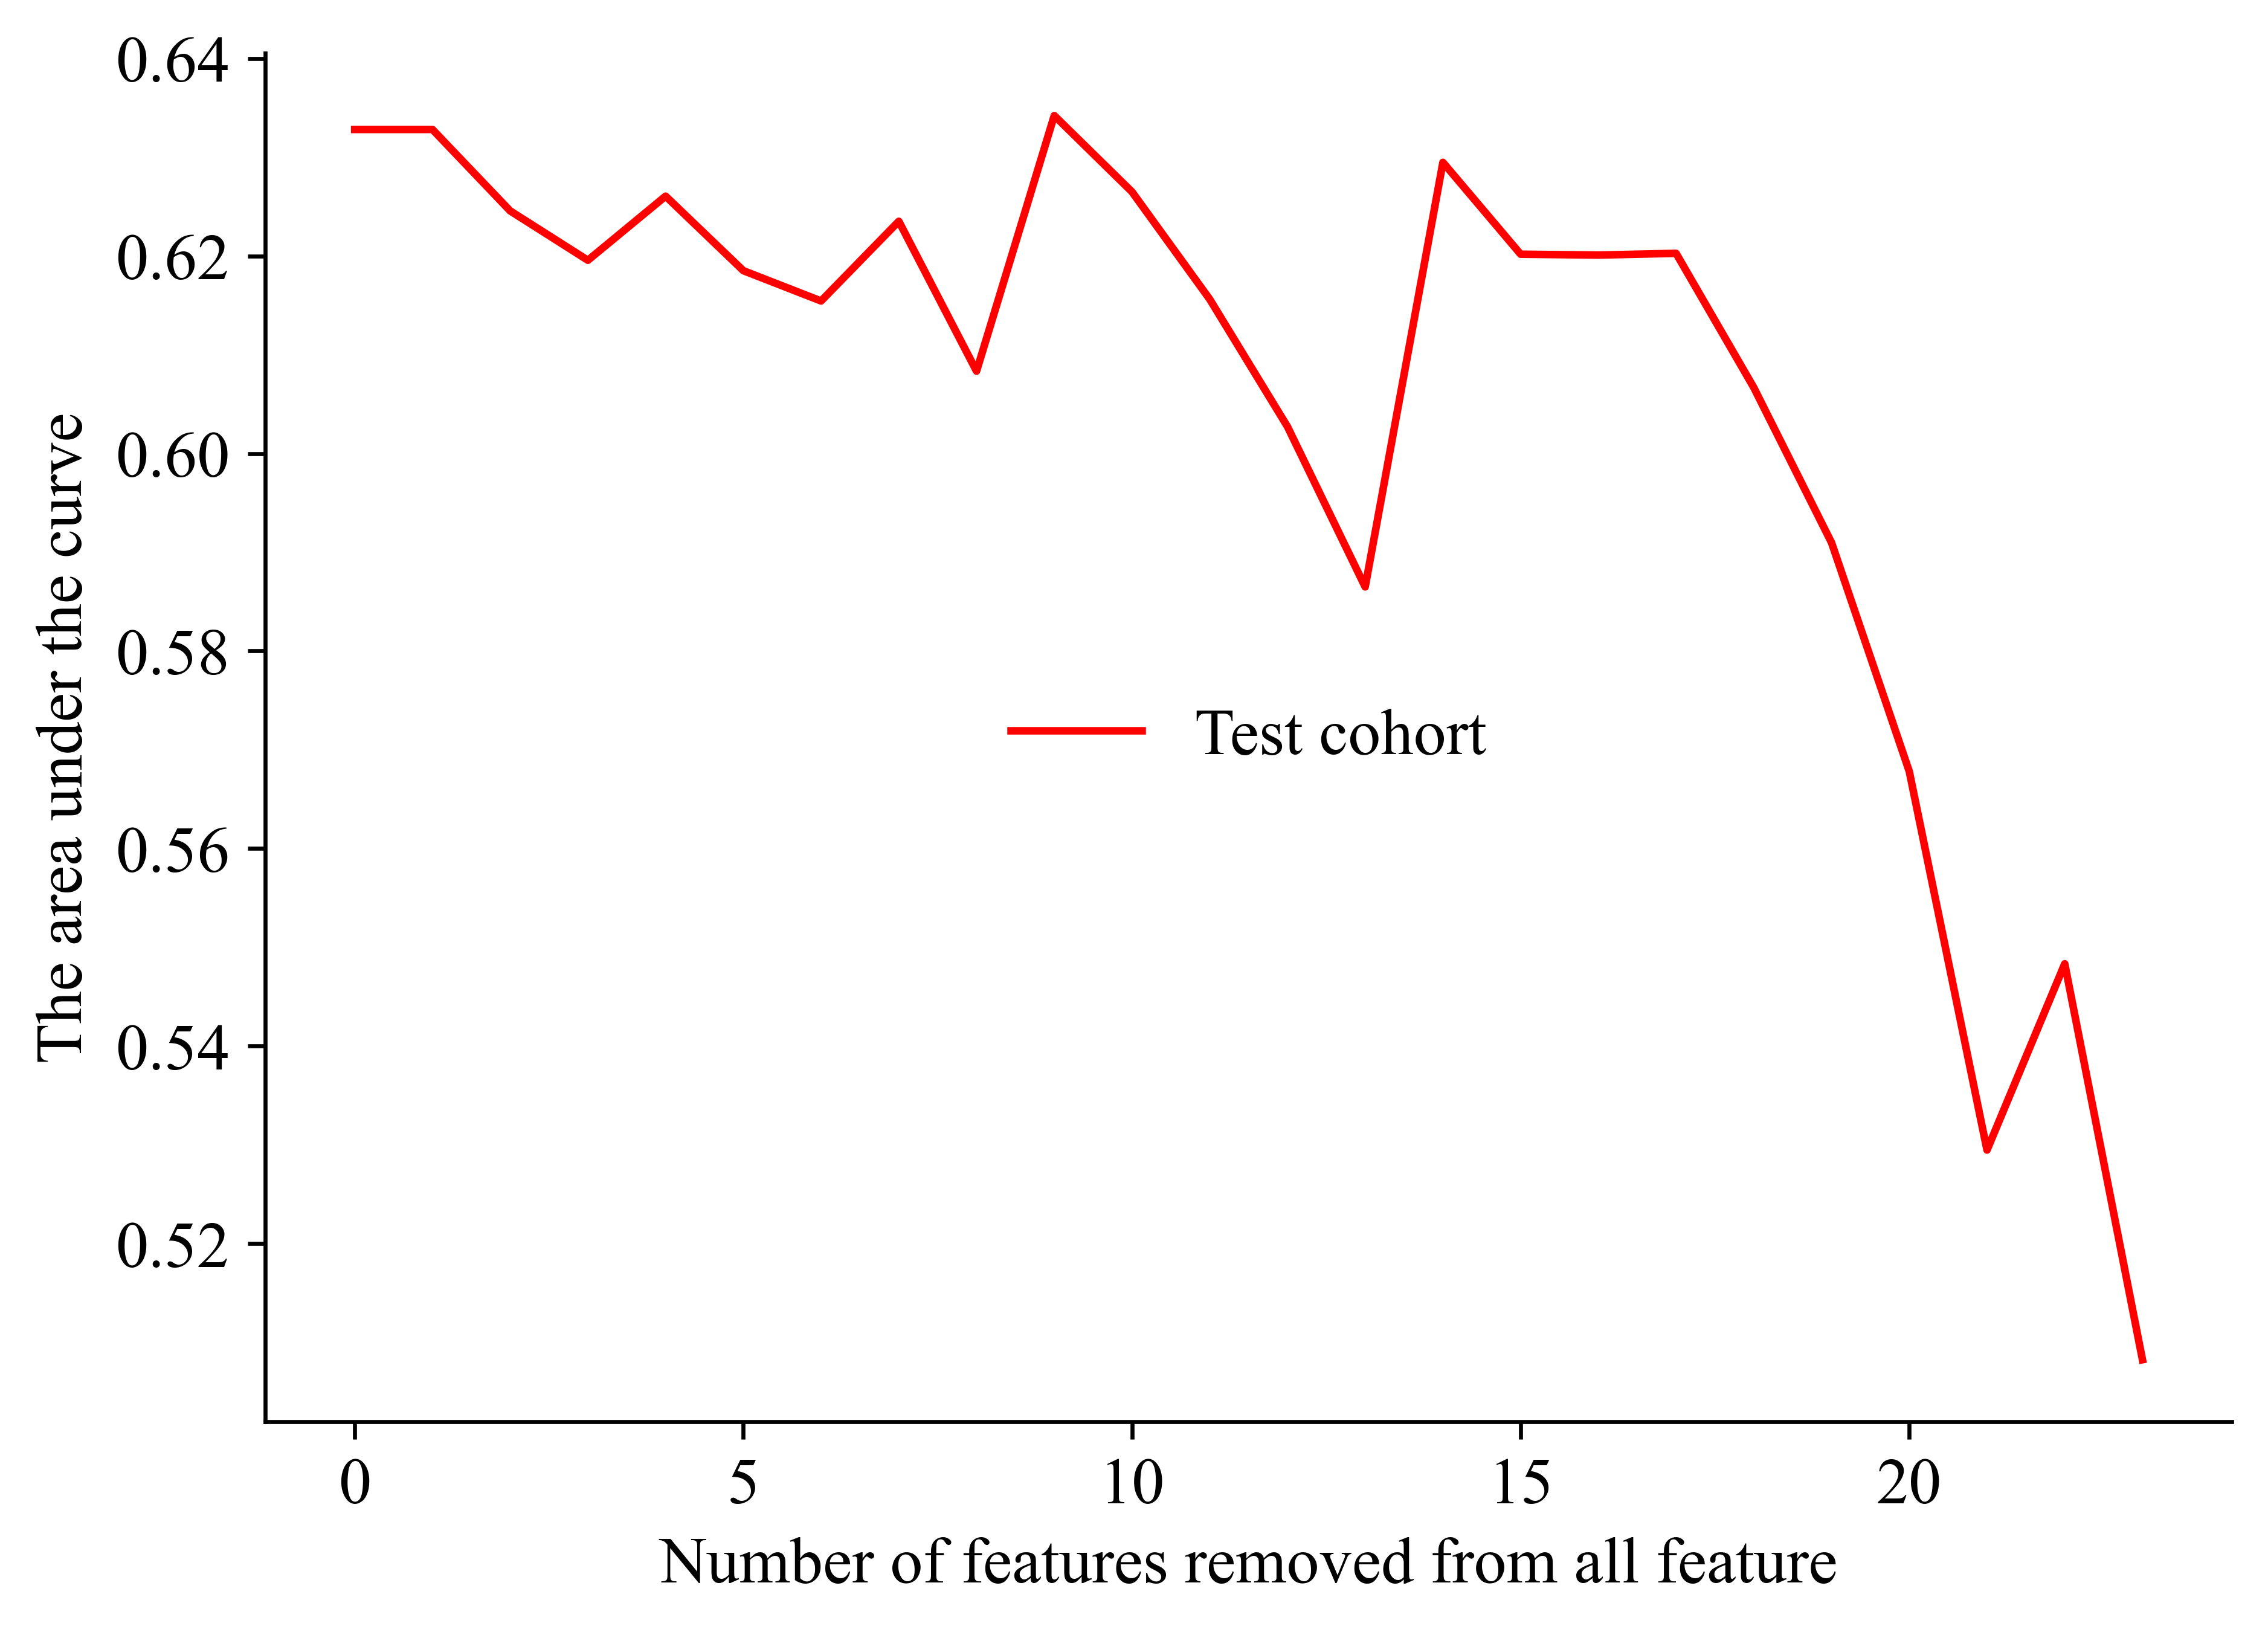

In [6]:
plt.figure(figsize=(7,5),dpi=600)

plt.plot(range(0,24),AUC,'r',label='Test cohort')

plt.yticks(fontproperties = 'Times New Roman', size = 13)
plt.xticks(fontproperties = 'Times New Roman', size = 13)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel('Number of features removed from all feature',fontdict={'family': 'Times New Roman','size': 13})
plt.ylabel('The area under the curve',fontdict={'family': 'Times New Roman','size': 13})

plt.legend(loc=10,prop={'family':'Times New Roman', 'size' :13},frameon=False)
plt.savefig('pic.jpg')
plt.show()